In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [50]:
import scipy
import laby
import pandas
from scipy import signal
import peakutils
from uncertainties import ufloat, umath
from uncertainties.umath import sin
import pint


plt.rcParams['figure.figsize'] = (18, 15)

In [4]:

_u = ureg = pint.UnitRegistry()
_u.default_dystem = 'cgs'


In [5]:
_u.define('M_sun = 1.989*10^30 kg')
_u.define('kpc = 1000 parsec')

In [273]:
raw = {i: pandas.read_csv('measurements/%d_0.csv' % i, header=None, names=['vel','temp']) for i in list(range(-90, 0)) + list(range(1, 90))}
data = {}
for l, v in raw.items():
    data[l] = v.to_records()
    #data[l].temp[v.temp < 15] = 0
    data[l] = data[l][abs(data[l].vel) < 200 ]
    

[143 185 205 270]
[141 151 172 189 195 218 284]
[ 77 109 130 163 186 205 234]
[161 175 197 218 236 259 269 283]
[135 192 198 221]


array([135, 192, 198, 221])

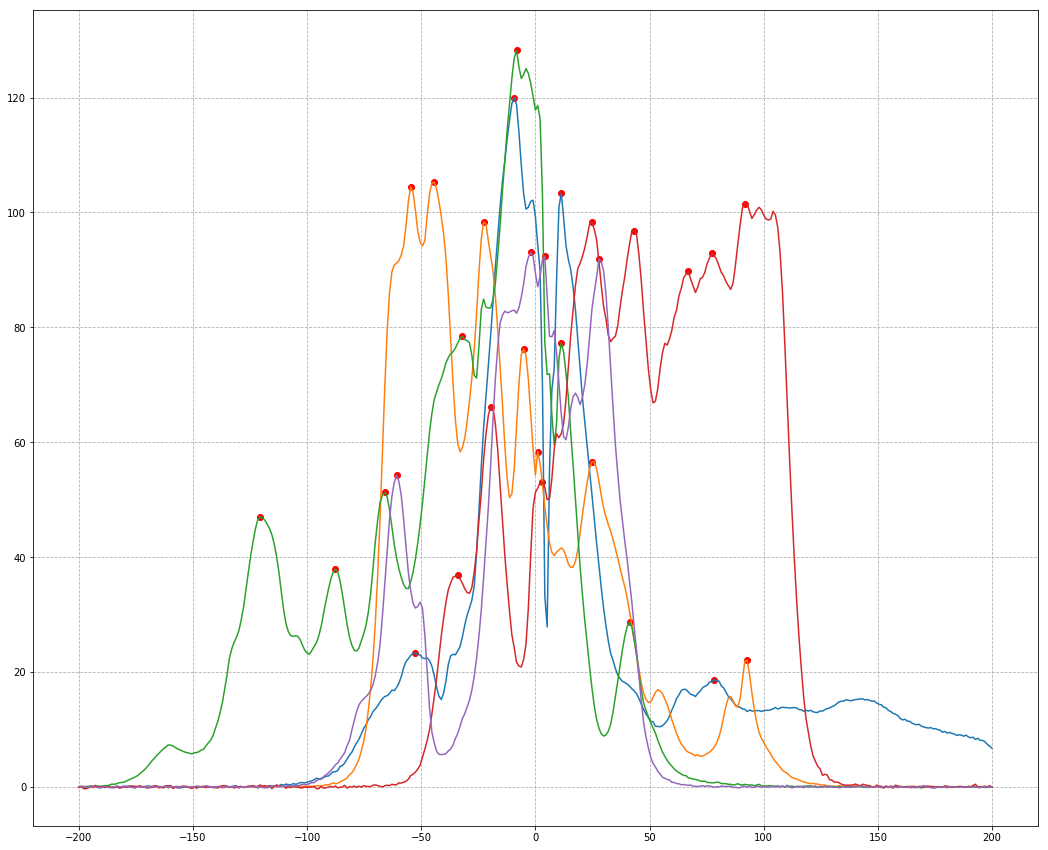

In [7]:
#plot(*lats[-60].values.transpose())
def plot_spec(meas):
    plot(meas.vel, meas.temp)
    #peaks = peakutils.indexes(meas.temp, thres=0.15, )
    peaks = signal.find_peaks(meas.temp, prominence=3)[0]
    peaks = peaks[meas.temp[peaks]>10]
    print(peaks)
    scatter(meas.vel[peaks], meas.temp[peaks], color='red')
    return peaks

grid(ls='--')
#plot_spec(lats[-90])
plot_spec(data[1])
#plot_spec(lats[-60])
plot_spec(data[-45])
#plot_spec(lats[-30])
plot_spec(data[-15])
#plot_spec(lats[15])
plot_spec(data[30])
#plot_spec(lats[45])
plot_spec(data[60])
#plot_spec(lats[75])


[192 203 212 235 277 371]


array([192, 203, 212, 235, 277, 371])

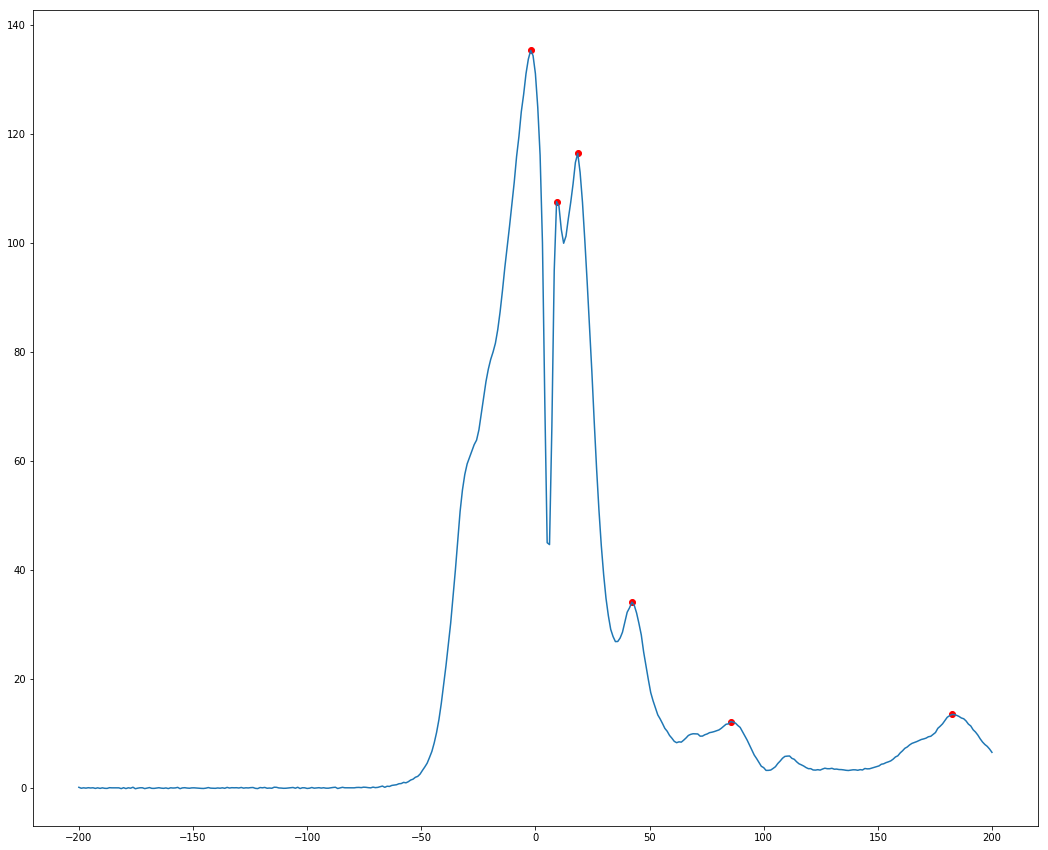

In [8]:
plot_spec(data[5])

In [10]:
from mpl_toolkits import mplot3d

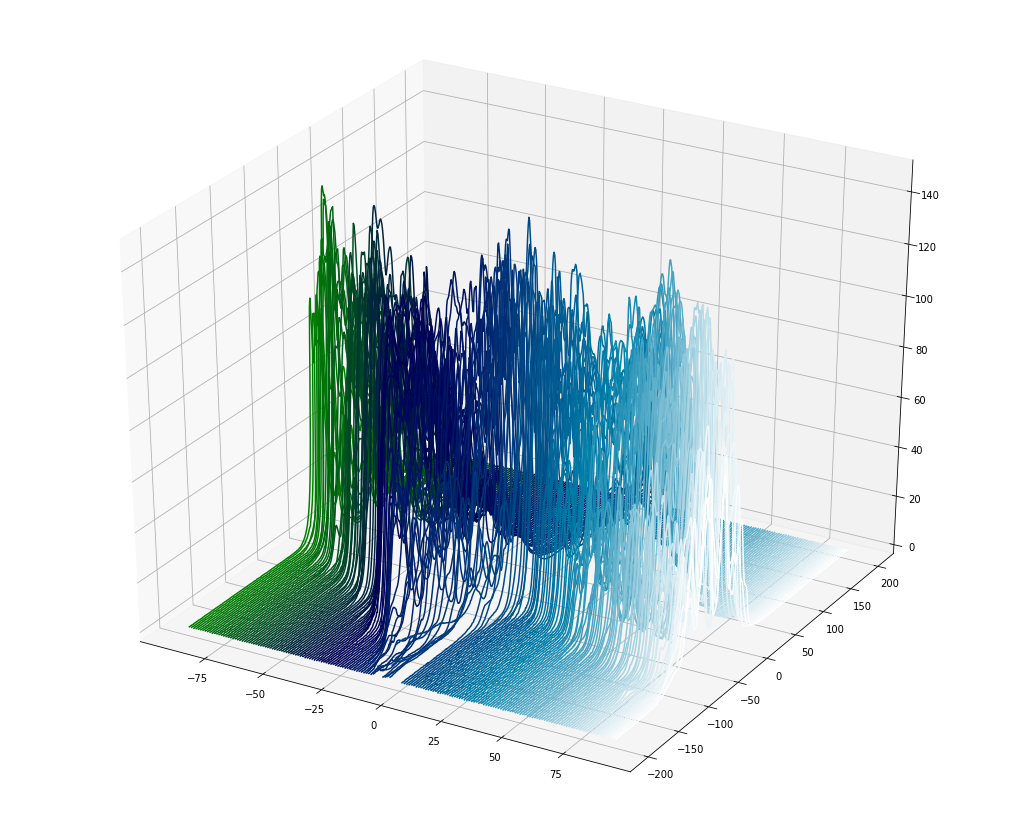

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
cmap = cm.ocean(linspace(0, 1, 180))
for l in data:
    ax.plot3D([l]*len(data[l]), data[l].vel, data[l].temp, color=cmap[l+90])
    
    

[135 192 198 221]


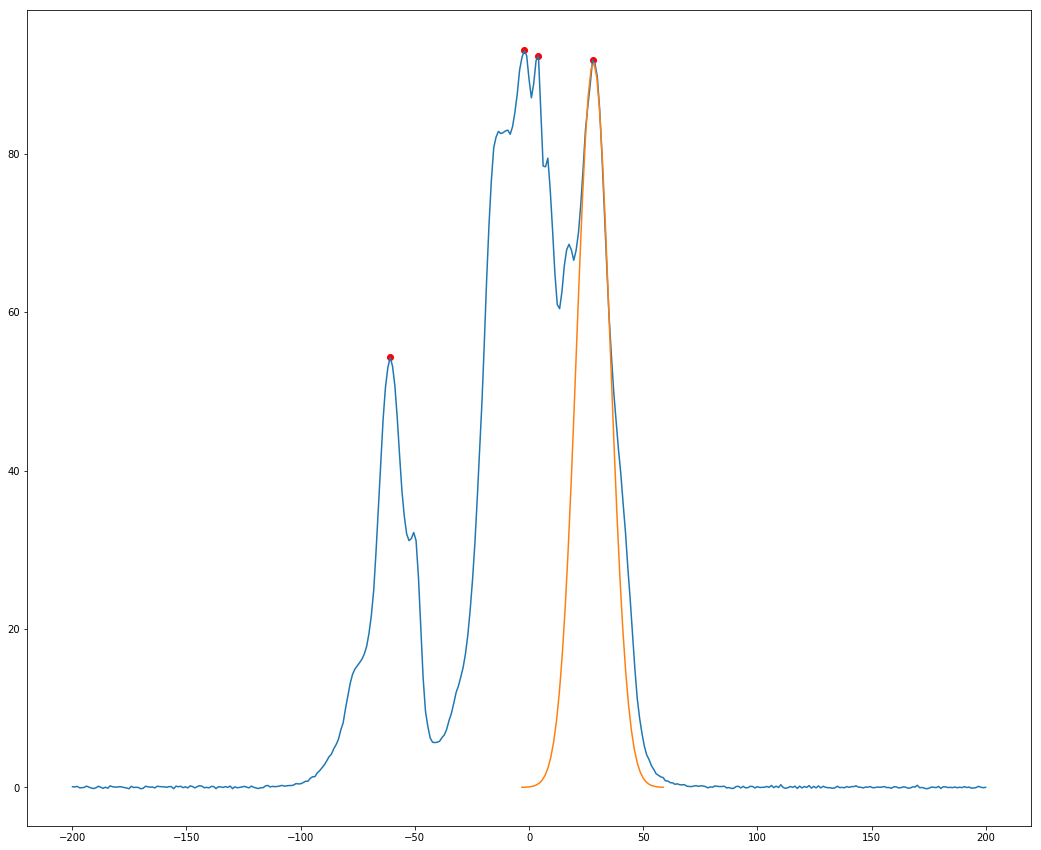

In [12]:
peaks = plot_spec(data[60])
lastpeak= peaks[-1]
gaus = peakutils.gaussian_fit(data[60].vel[lastpeak-3:lastpeak+5], data[60].temp[lastpeak-3:lastpeak+5], False)
sp = linspace(data[60].vel[lastpeak-30], data[60].vel[lastpeak+30], 50)
plot(sp, peakutils.gaussian(sp, *gaus))

In [287]:
_u.default_units = 'cgs'

R0 = ufloat(8.122, 0.0338)* 1000 *_u('parsec')  # kpc, from https://iopscience.iop.org/article/10.3847/2515-5172/aaef8b
V0 = ufloat(233.4, 1.5) *_u('km/s') # km/s, distance from LSR, same source
G = ufloat(6.67430e-11, 0.00015e-11) *ureg.m**3 *ureg.kg**-1*ureg.s**-2

class Cloud: 
    def __init__(self, sample, latitude, peaks=None, start=-inf, stop=inf, cutoff=15):
        self.latitude = ufloat(latitude, 1/sqrt(12))
        self.sample = sample
        
        #peaks = peakutils.indexes(sample.temp, thres=0.13)
        
        if peaks is None:
            peaks = signal.find_peaks(sample.temp, prominence=1.5)[0]
            peaks = peaks[(sample.temp[peaks]>cutoff) & (start < sample.vel[peaks])& (sample.vel[peaks] < stop)]
        
        self.fit_peak(peaks[-1] if latitude > 0 else peaks[0])
        
    def fit_peak(self, idx):
        if self.latitude.n > 0:
            start, stop = idx - 3, idx + 5
        else:
            start, stop = idx - 5, idx + 3
            
        self.peakind = idx
        self.peak = peakutils.gaussian_fit(self.sample.vel[start:stop], self.sample.temp[start:stop], False)
        
        A, 𝜇, 𝜎 = self.peak
        self.T = A  # TODO error
        self.Vr = ufloat(𝜇, 𝜎) * _u('km/s')
        self.Vr = self.Vr.to(_u('cm/s'))
        self.Vt = self.Vr + V0.to(_u('cm/s'))*sin(self.latitude/360*2*pi)
        self.R = R0.to(_u('cm')) * sin(abs(self.latitude)/360*2*pi)
        self.M_cu  = (self.Vt**2*self.R/G).to_base_units()
        
    def index_for_vel(self, vel):
        for i in range(len(self.sample)-1):
            if self.sample.vel[i] <= vel <= self.sample.vel[i+1]:
                return i
        return None
    
    def plot(self):
        sp = linspace(self.sample.vel[max(self.peakind-30, 0)], self.sample.vel[min(self.peakind+30, len(self.sample)-1)], 50)
        plot(self.sample.vel, self.sample.temp)
        A, 𝜇, 𝜎 = self.peak
        plot(sp, peakutils.gaussian(sp,  A, 𝜇, 𝜎))
        vlines([𝜇 - 𝜎, 𝜇 + 𝜎, ], [0, 0], peakutils.gaussian(np.array([𝜇 - 𝜎, 𝜇 + 𝜎, ]),  A, 𝜇, 𝜎), color='red', linestyle='--')
        hlines(A/2,𝜇 - 𝜎, 𝜇 + 𝜎, 'r')
        grid()
        
clouds = [Cloud(data[l], l) for l in data]

def fix_cloud(idx, **new_params):
    clouds[idx] = Cloud(clouds[idx].sample, clouds[idx].latitude.n, **new_params)
for i in range(90, 99):
    fix_cloud(i, start=50, stop=100, cutoff=0)
for i in range(81, 90):
    fix_cloud(i, start=-100, stop=-50, cutoff=0)

Text(0.5, 1.0, 'Intensity (K)')

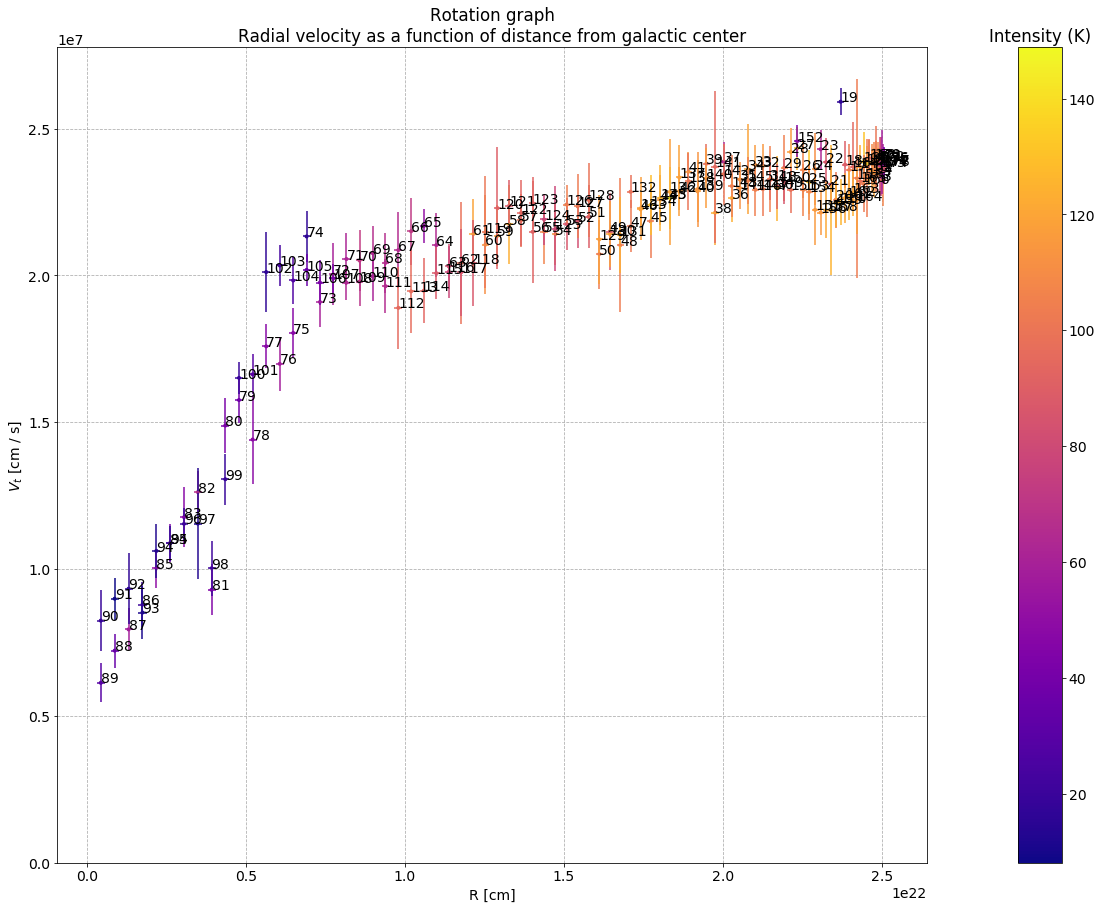

In [288]:
rot_data = pandas.DataFrame(data=[(c.T, c.Vt.n, c.Vt.s, c.R.n, c.R.s) for c in clouds], columns=["temp", "vel", "vel_err", "radius", "radius_err"])
#errorbar(rot_data.radius, abs(rot_data.vel),
#         yerr=rot_data.vel_err, xerr=rot_data.radius_err, 
#         ecolor='red', elinewidth=0.3,  
#         linewidth=0, markersize=0)
temp_norm = mpl.colors.Normalize(vmin=rot_data.temp.min(), vmax=rot_data.temp.max())
cmap = cm.ScalarMappable(temp_norm, cm.plasma)
fig, (ax1, ax2) =  plt.subplots(1, 2, gridspec_kw={'width_ratios': [20, 1], 'hspace': 0})
ax1.vlines(rot_data.radius, abs(rot_data.vel)-rot_data.vel_err, abs(rot_data.vel)+rot_data.vel_err,
      color=cmap.to_rgba(rot_data.temp), )
ax1.hlines(abs(rot_data.vel), rot_data.radius -rot_data.radius_err, rot_data.radius +rot_data.radius_err,
         color=cmap.to_rgba(rot_data.temp))
ax1.scatter(rot_data.radius,abs(rot_data.vel),
         color=cmap.to_rgba(rot_data.temp), marker='.')
ax1.set_xlabel(f'R [{clouds[0].R.u:~}]')
ax1.set_ylabel(f'$V_t$ [{clouds[0].Vt.u:~}]')
for i, r in rot_data.iterrows():
    ax1.annotate(str(i), (r.radius, abs(r.vel)))
ax1.grid(ls='--')
ax1.set_ylim(0)
ax1.set_title('Rotation graph\nRadial velocity as a function of distance from galactic center')

mpl.colorbar.ColorbarBase(ax2, cm.plasma, temp_norm)
ax2.set_title('Intensity (K)')

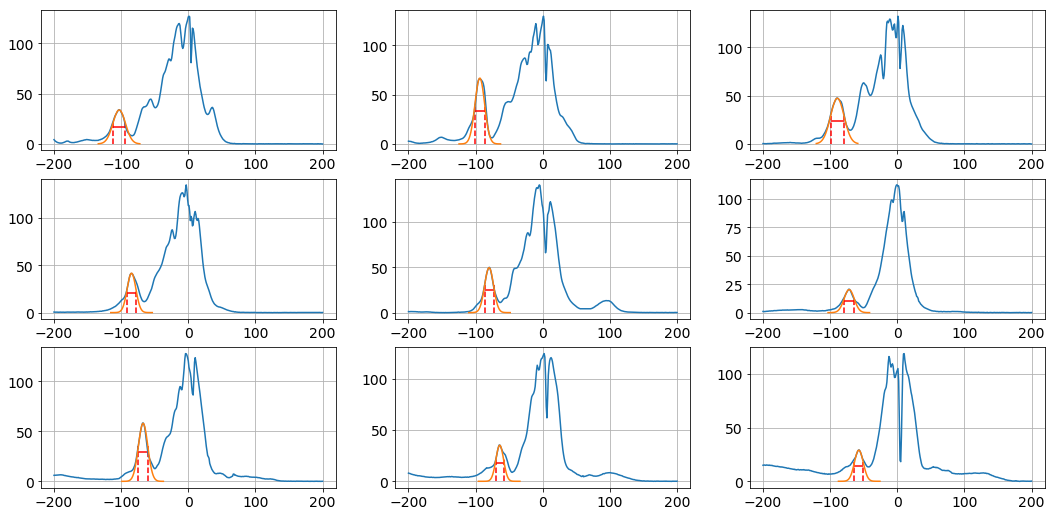

In [282]:
annoying = range(81, 90)#[90,91,92,93,94,95,96]

for i,a in enumerate(annoying):
    plt.subplot(5,3,i+1)
    clouds[a].plot()

for i in [90,91,92,93,94,95]:
    clouds[i] = Cloud(clouds[i].sample, clouds[i].latitude.n, start=50,stop=100, cutoff=0)

[Errors for log graphs](https://faculty.washington.edu/stuve/log_error.pdf)

In [267]:
%history

_u.default_units = 'cgs'

R0 = ufloat(8.122, 0.0338)* 1000 *_u('parsec')  # kpc, from https://iopscience.iop.org/article/10.3847/2515-5172/aaef8b
V0 = ufloat(233.4, 1.5) *_u('km/s') # km/s, distance from LSR, same source
G = ufloat(6.67430e-11, 0.00015e-11) *ureg.m**3 *ureg.kg**-1*ureg.s**-2

class Cloud: 
    def __init__(self, sample, latitude, peaks=None):
        self.latitude = ufloat(latitude, 1/sqrt(12))
        self.sample = sample
        
        #peaks = peakutils.indexes(sample.temp, thres=0.13)
        if peaks is None:
            peaks = signal.find_peaks(sample.temp, prominence=2)[0]
            peaks = peaks[(sample.temp[peaks]>15) & (abs(sample.vel[peaks]) < 175)]
        if latitude > 0:
            lastpeak= peaks[-1]
        else:
            lastpeak = peaks[0]
        self.fit_peak(lastpeak)
        A, 𝜇, 𝜎 = self.peak
        self.T = A  # TODO error
        self.Vr = ufloat(𝜇, 𝜎) * _u('km/s')
        self.Vr = self.Vr.to(_u('cm/s'))
        self.Vt = self.Vr + 

Text(0.5, 1.0, 'Rotation graph (log)\nRadial velocity as a function of distance from galactic center')

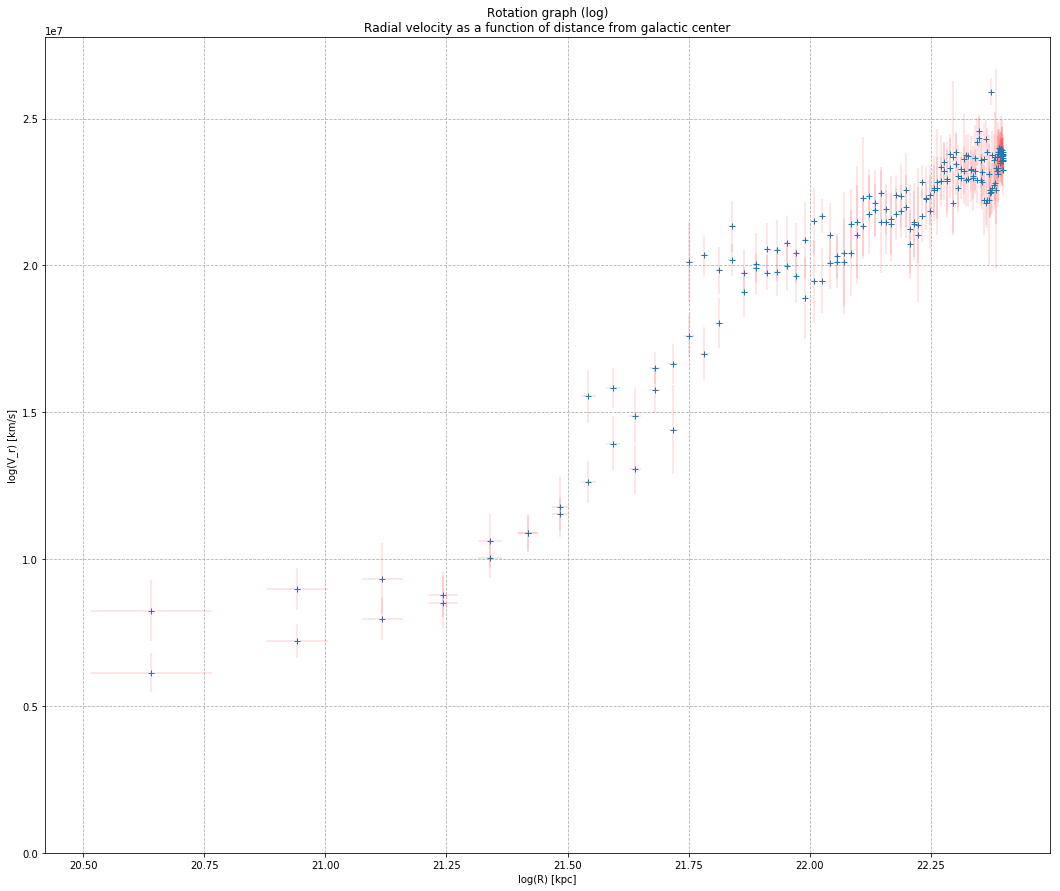

In [93]:
errorbar(log10(rot_data.radius), abs(rot_data.vel), 
        xerr=0.434*abs(rot_data.radius_err/rot_data.radius), yerr=rot_data.vel_err,
        ecolor='red', elinewidth=0.2, linewidth=0, marker='+')
xlabel('log(R) [kpc]')
ylabel('log(V_r) [km/s]')
grid(ls='--')
ylim(0)
title('Rotation graph (log)\nRadial velocity as a function of distance from galactic center')

# Mass distribution models

## Hernequist - Baryonic matter
$$ M(r) = M_0\frac{r^2}{(r+a)^2} $$
$$ V(r) = \sqrt{\frac{GM(r)}{r}} = \frac{\sqrt{M_0G r}}{r+a} =b\frac{\sqrt{r}}{r+a}  $$

In [96]:
def hernequist_mass(r, a, M):
    """ Cumulative mass distribution """
    return M * r**2 / (r + a)**2

def hernequist_velocity(r, a, b):
    return b * r**.5/(r+a)

Testing with small (<2kpc) radius:

In [97]:
G=6.67430e-11 *ureg.m**3 *ureg.kg**-1*ureg.s**-2
M0 = 5e30 * ureg.kg

Fit parameters:
  a1 = 10.40+/-0.20 (0.0189\%)
  a2 = 1.98+/-0.64 (0.322\%)
X^2 = 15.10043
X^2_reduced = 0.94 (=~ 1)
p_value = 0.52 (GOOD)
a=(2.5+/-1.1)e+10 M_sun , b=2.0+/-0.6 kpc


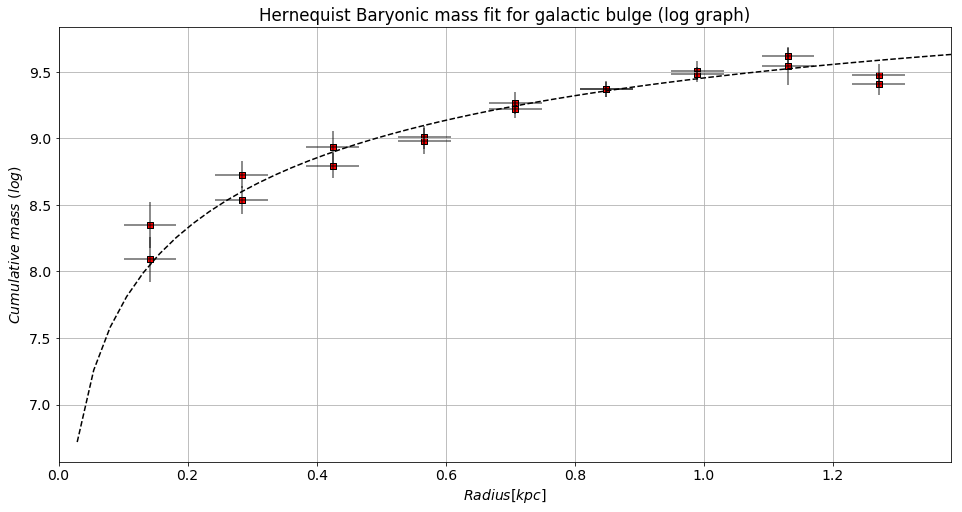

In [316]:
# log fit
selected = [c for c in clouds if c.R <1.3*_u('kpc')]
selected.sort(key=lambda c: (c.R, c.Vt))
d1 = laby.Data(x=[c.R.to('kpc') for c in selected], 
               y=[umath.log10(c.M_cu.to('M_sun').magnitude) for c in selected],
              x_unit='kpc', x_name='Radius', y_name=r'Cumulative\ mass\ (log)')
# model = laby.Model(lambda a, x: hernequist_velocity(x,a[0], a[1]), name="Hernequist Baryonic Mass", params=2)
hernequist_log_model = laby.Model(lambda a, x: a[0]+2*log10(x)-2*(log10(x+a[1])), name="Hernequist Baryonic Mass", params=2)
hq_bulge_fit=d1.fit(hernequist_log_model, guess=[1, 1])
# output=d1.fit(model, guess=[2, umath.log10(10**10*M0.to_base_units().magnitude)])
hq_bulge_fit.plot_data(title='Hernequist Baryonic mass fit for galactic bulge (log graph)')
xlim(0)
hq_bulge_fit.pprint()
hq_bulge_fit.mass = 10**hq_bulge_fit.params[0]*_u('M_sun')
hq_bulge_fit.radius =  b=hq_bulge_fit.params[1]*_u('kpc')
print(f'a={hq_bulge_fit.mass} , b={hq_bulge_fit.radius}')

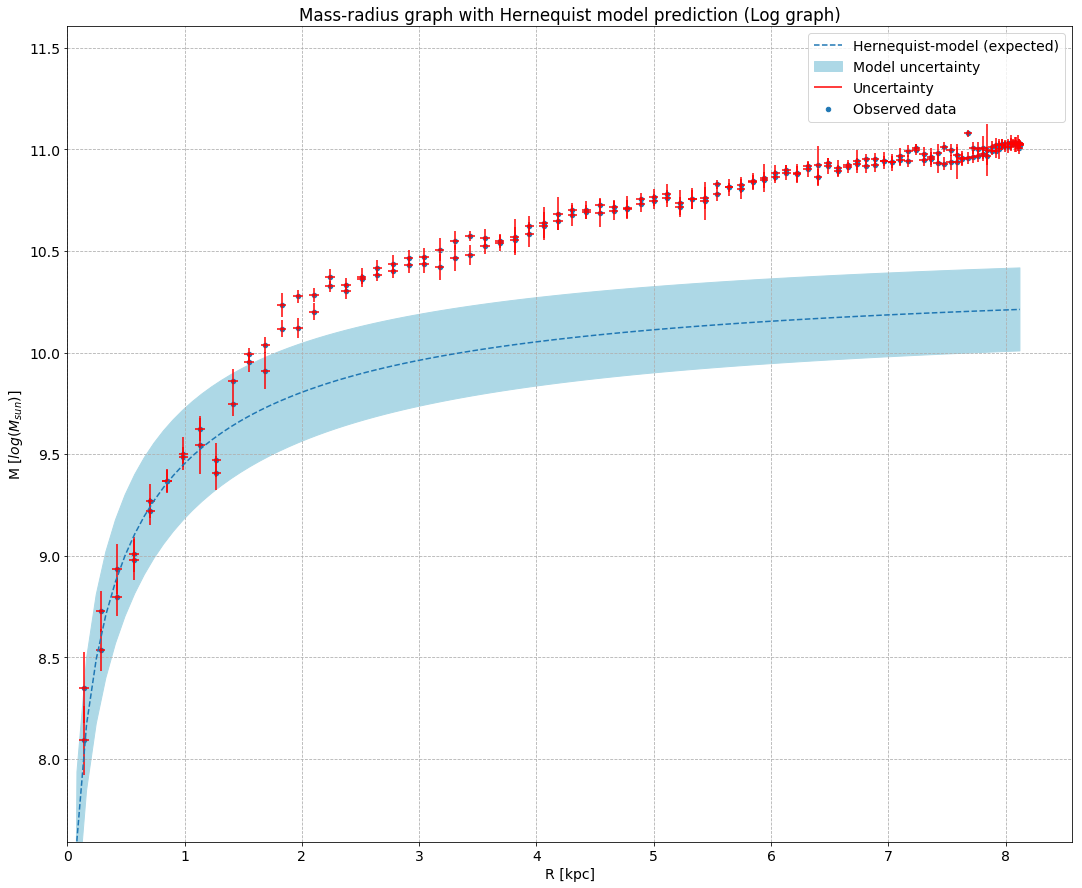

In [292]:
mass_data = pandas.DataFrame(data=[(log10(c.M_cu.to('M_sun').n), 0.434*(c.M_cu.s/c.M_cu.n), c.R.to('kpc').n, c.R.to('kpc').s) for c in clouds], columns=["mass","mass_err", "radius", "radius_err"])

ax1 = gca()
# Hernequist mass using our fit parameters
xs = linspace(0.0001, mass_data.radius.max(), 100)
ys = [umath.log10(y) for y in hernequist_mass(xs, hq_bulge_fit.radius.magnitude, hq_bulge_fit.mass.magnitude)]
ax1.plot(xs, [y.n for y in ys], '--', label='Hernequist-model (expected)')
ax1.fill_between(xs, [y.n-y.s for y in ys], [y.n+y.s for y in ys], color='lightblue', label='Model uncertainty')

ax1.vlines(mass_data.radius, mass_data.mass-mass_data.mass_err, mass_data.mass+mass_data.mass_err, color='r', label='Uncertainty')
ax1.hlines(mass_data.mass, mass_data.radius -mass_data.radius_err, mass_data.radius +mass_data.radius_err, color='r', label=None)
ax1.scatter(mass_data.radius, mass_data.mass, s=20, label='Observed data')
ax1.set_xlabel(f'R [kpc]')
ax1.set_ylabel('M [$log(M_{sun}$)]')
ax1.grid(ls='--')
#ax1.set_ylim(0)
ax1.set_title('Mass-radius graph with Hernequist model prediction (Log graph)')
ax1.set_xlim(0)
ax1.set_ylim(mass_data.mass.min()-0.5)
legend()

6.16595001861481

In [110]:
(44.69e22*_u.cm).to('parsec')

144830.30119533613 <Unit('parsec')>

[1.0+/-0.2886751345948129, 2.0+/-0.2886751345948129, 3.0+/-0.2886751345948129, 4.0+/-0.2886751345948129, 5.0+/-0.2886751345948129, 6.0+/-0.2886751345948129, 7.0+/-0.2886751345948129, 8.0+/-0.2886751345948129]


<Figure size 1296x1080 with 0 Axes>

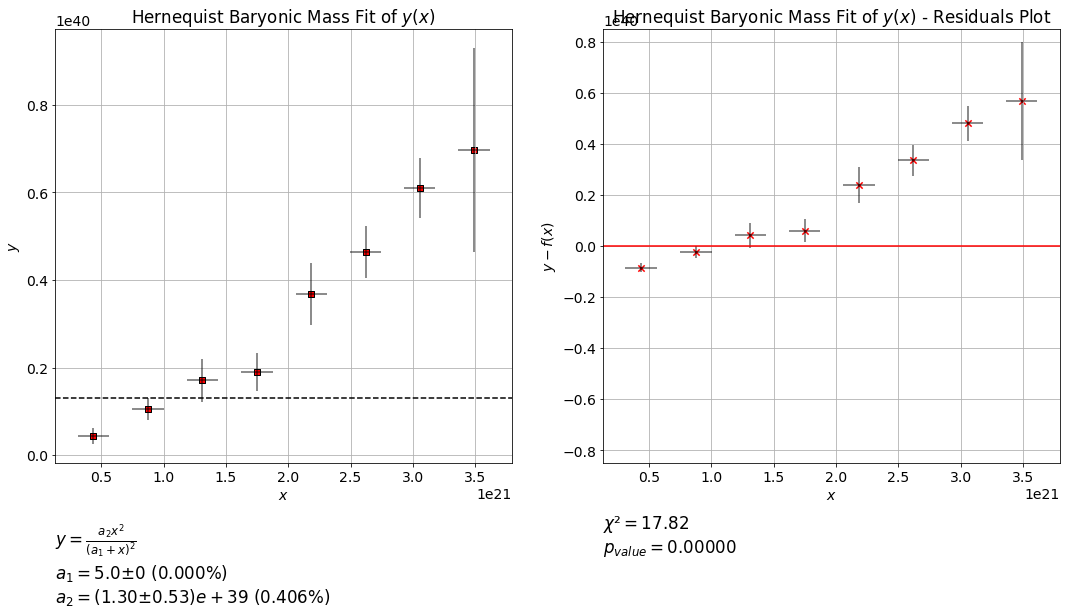

In [108]:
## selected = [c for c in clouds if c.R < 1200*_u('parsec') and c.Vt.n > 0]
print([s.latitude for s in selected])
selected.sort(key=lambda c: (c.R, c.Vt))
d1 = laby.Data(x=[c.R.n for c in selected], 
               y=[c.M_cu.n for c in selected], 
               sx=[c.R.s for c in selected], 
               sy=[c.M_cu.s for c in selected])
# model = laby.Model(lambda a, x: hernequist_velocity(x,a[0], a[1]), name="Hernequist Baryonic Mass", params=2)
model = laby.Model(lambda a, x: hernequist_mass(x,a[0], a[1]), name="Hernequist Baryonic Mass", params=2)
output=d1.fit(model, guess=[5, 10])
#output=d1.fit(model, guess=[(4e3*_u.parsec).to_base_units().magnitude, M0.to_base_units().magnitude])
output.plot()

18267867965364.758

/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


<Figure size 1296x1080 with 0 Axes>

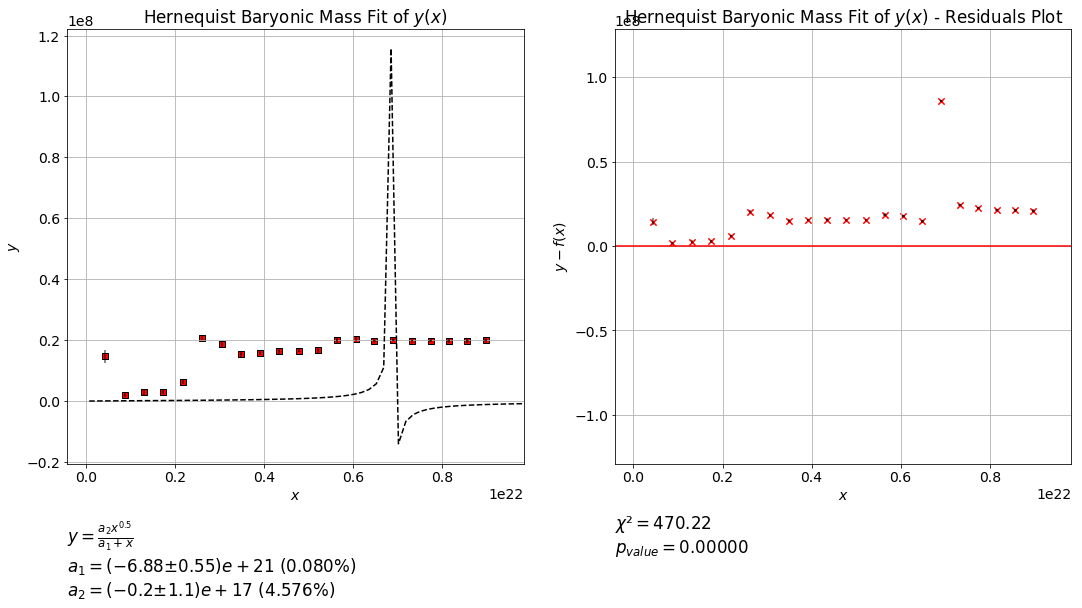

In [407]:
selected = [c for c in clouds if c.R < 3000*_u('parsec') and c.Vt.n > 0]
selected.sort(key=lambda c: (c.R, c.Vt))
d1 = laby.Data(x=[c.R.n for c in selected], y=[abs(c.Vt.n) for c in selected], sx=[c.R.s for c in selected], sy=[c.Vt.s for c in selected])
# model = laby.Model(lambda a, x: hernequist_velocity(x,a[0], a[1]), name="Hernequist Baryonic Mass", params=2)
model = laby.Model(lambda a, x: hernequist_velocity(x,a[0], a[1]), name="Hernequist Baryonic Mass", params=2)
output=d1.fit(model, guess=[(4e3*_u.parsec).to_base_units().magnitude, ((G*M0)**.5).to_base_units().n])
output.plot()

## Dark matter - Burkert, NFW
Burkert:
$$ \rho(r) = \rho_0\left\{\left(1+\frac{r}{r_s}\right)\left[1+\left(\frac{r}{r_s}\right)^2\right]\right\}^{-1} $$

NFW:
$$ \rho(r) = \rho_0\left[\frac{r}{r_s}\left(1+\frac{r}{r_s}\right)^2\right]^{-1} $$


In [332]:
def burkert_density(r, rho0, r_s):
    ratio = r/r_s
    return rho0/((1+ratio)*(1+ratio**2))

def vol_sphere(r):
    return 4/3*pi*r**3

def nfw_density(r, rho0, r_s):
    ratio = r/r_s
    return rho0/(ratio*(1+ratio)**2)

def burkert_hernequist(r, r_b, m_b, rho0, r_s):
    return hernequist_mass(r, r_b, m_b) + burkert_density(r, rho0, r_s) * vol_sphere(r)

def nfw_hernequist(r, r_b, m_b, rho0, r_s):
    return hernequist_mass(r, r_b, m_b) + nfw_density(r, rho0, r_s) * vol_sphere(r)

Fit parameters:
  a1 = (0.7+/-2.5)e+06 (3.4\%)
  a2 = (0.6+/-2.1)e+03 (3.33\%)
X^2 = 2030.73109
X^2_reduced = 11.47 (>> 1)
p_value = 0.00 (WTF)


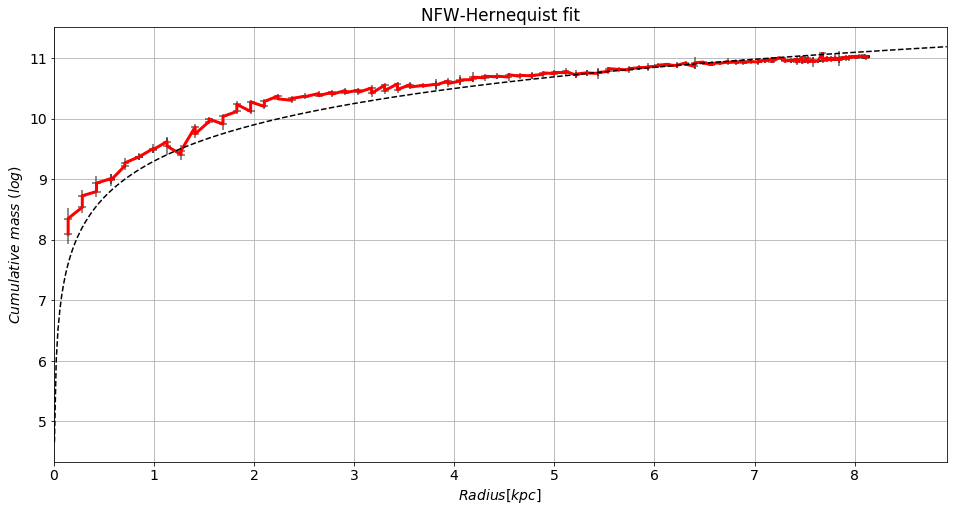

In [333]:
# log fit
selected = [c for c in clouds]#[c for c in clouds if c.R <1.3*_u('kpc')]
selected.sort(key=lambda c: (c.R, c.Vt))
d1 = laby.Data(x=[c.R.to('kpc') for c in selected], 
               y=[umath.log10(c.M_cu.to('M_sun').magnitude) for c in selected],
              x_unit='kpc', x_name='Radius', y_name=r'Cumulative\ mass\ (log)')
# model = laby.Model(lambda a, x: hernequist_velocity(x,a[0], a[1]), name="Hernequist Baryonic Mass", params=2)
nfw_model = laby.Model(lambda a, r: log10(nfw_hernequist(r, *a)), name="NFW-Hernequist", params=4)
nfw_2param = laby.Model(lambda a, r: log10(nfw_hernequist(r, hq_bulge_fit.radius.n, hq_bulge_fit.mass.n, *a)), name="NFW-Hernequist", params=2)
#nfw_fit=d1.fit(nfw_model, guess=[hq_bulge_fit.radius.n, hq_bulge_fit.mass.n, 10, 10])
nfw_fit=d1.fit(nfw_2param, guess=[10, 10])

# output=d1.fit(model, guess=[2, umath.log10(10**10*M0.to_base_units().magnitude)])
nfw_fit.plot_data(title='NFW-Hernequist fit')
xlim(0)
nfw_fit.pprint()

In [ ]:
# model = laby.Model(lambda a, x: hernequist_velocity(x,a[0], a[1]), name="Hernequist Baryonic Mass", params=2)
nfw_model = laby.Model(lambda r, a: log10(nfw_hernequist(r, hq_bulge_fit.radius, hq_bulge_fit.mass, *a)), name="NFW-Hernequist", params=2)
nfw_fit=d1.fit(hernequist_log_model, guess=[1, 1])
# output=d1.fit(model, guess=[2, umath.log10(10**10*M0.to_base_units().magnitude)])
nfw_fit.plot_data(title='NFW-Hernequist fit')
xlim(0)
nfw_fit.pprint()

In [259]:
R0.to_base_units()

2.50618949905e+22+/-1.0429599244999998e+20 <Unit('centimeter')>

In [263]:
R0.magnitude

8122.0+/-33.8

In [504]:
u=ufloat(1,1)
